# Predicting Credit Card Defaults with Machine Learning

## Erhan Asad Javed & Jun He Cui

<!-- BEGIN QUESTION -->

## Imports

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC

## 1. Introduction

We are trying to assess the roles of different variables in predicting default payment (when a person defaults their credit card bills). We have feature variables such as basic identity features of clients (gender, education level etc.) and we have more quantitative variables such as the ordinal repayment status in several months, amount of bill statements (in dollars), and amount paid (in dollars) for several months, and limit balance.

My first few thoughts are that we should maybe drop columns like marriage status and gender since they do not really play a pivotal role and may affect the results, however we will consider this after initial exploratory data analysis.

In [3]:
credit_df = pd.read_csv("../data/UCI_Credit_Card.csv", index_col=0)
credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<!-- END QUESTION -->

<br><br>

## 2. Data splitting

In [4]:
X = credit_df.drop(["default.payment.next.month"], axis=1)
y = credit_df["default.payment.next.month"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

<!-- END QUESTION -->

<br><br>


## 3. EDA

Mean and Standard Deviation of LIMIT_BAL (Credit Amount): Summarizing LIMIT_BAL gives insights into the typical credit limit and variability, helping to understand financial exposure.

Class Distribution for default.payment.next.month: Showing the proportion of clients who default provides context for class imbalance, a critical consideration for model evaluation.

Histogram of AGE: A histogram shows age distribution, useful for understanding the demographic makeup and possible relationships with default likelihood.

Boxplot of BILL_AMT1 by Default Status: A boxplot can reveal trends in outstanding bill amounts and their link to default, possibly identifying financial strain.

Mean and Standard Deviation of LIMIT_BAL:
167880.65142857144 130202.68216737211

Class Distribution in y_train:
default.payment.next.month
0    0.776762
1    0.223238
Name: proportion, dtype: float64


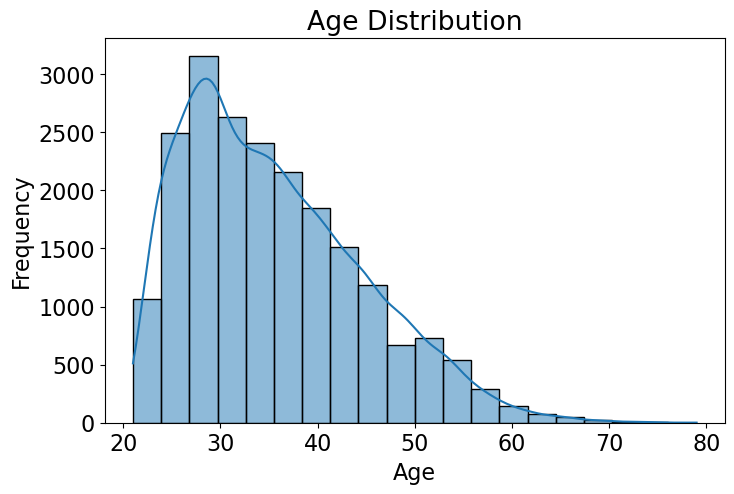

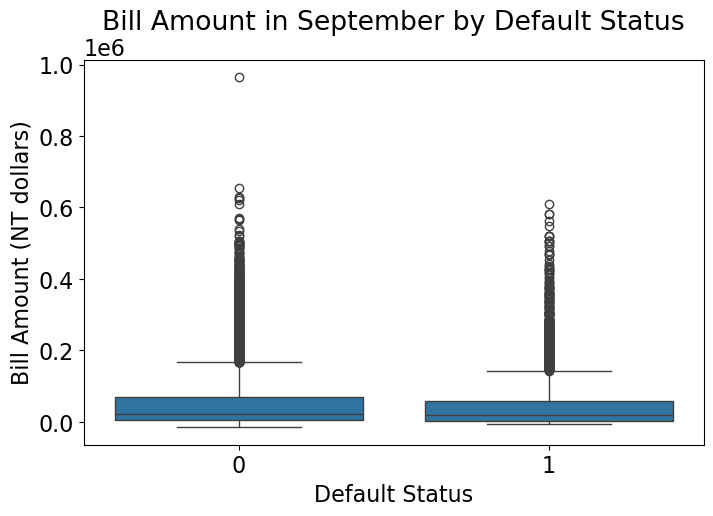

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Summary statistics
print("Mean and Standard Deviation of LIMIT_BAL:")
print(X_train["LIMIT_BAL"].mean(), X_train["LIMIT_BAL"].std())

# Class distribution
print("\nClass Distribution in y_train:")
print(y_train.value_counts(normalize=True))

# Visualization: Age histogram
plt.figure(figsize=(8, 5))
sns.histplot(X_train["AGE"], bins=20, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Visualization: Boxplot of BILL_AMT1 by Default Status
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y=X_train["BILL_AMT1"])
plt.title("Bill Amount in September by Default Status")
plt.xlabel("Default Status")
plt.ylabel("Bill Amount (NT dollars)")
plt.show()

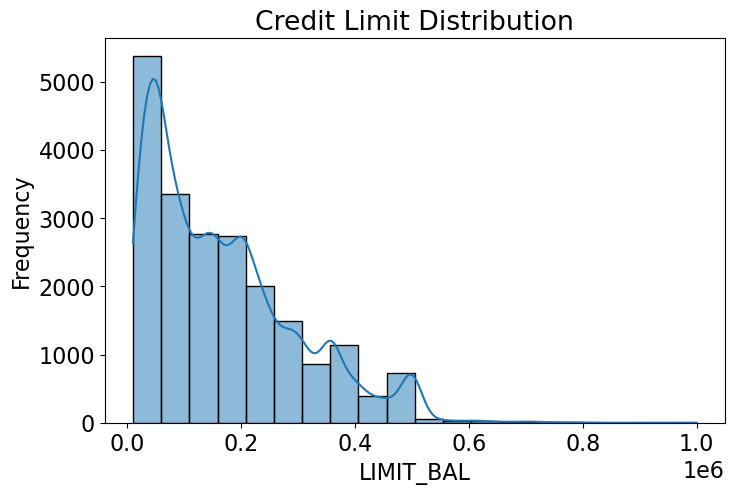

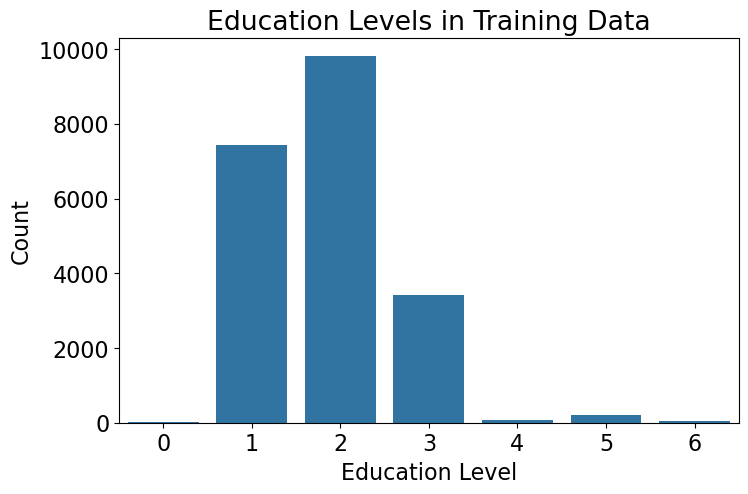

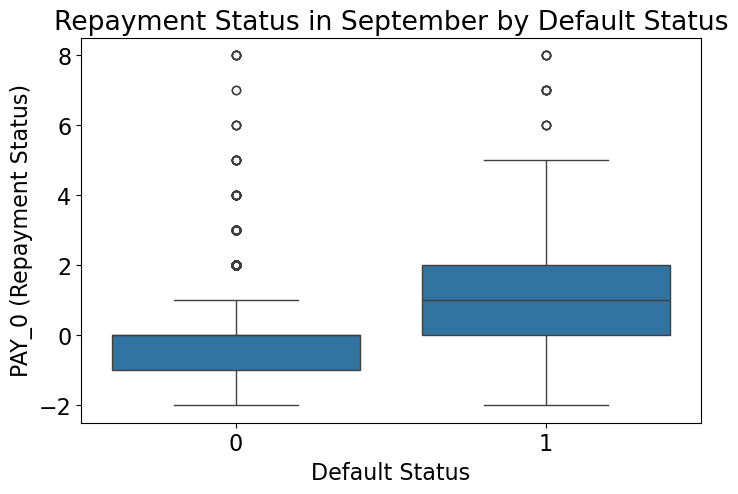

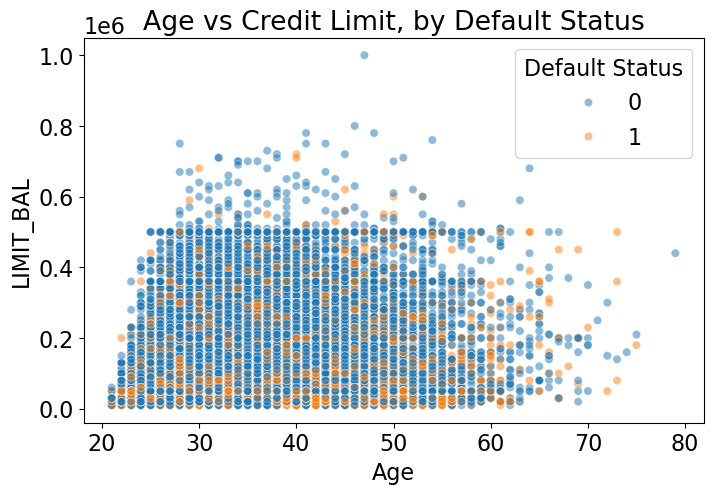

In [6]:
# Visualization: Histogram of LIMIT_BAL
plt.figure(figsize=(8, 5))
sns.histplot(X_train["LIMIT_BAL"], bins=20, kde=True)
plt.title("Credit Limit Distribution")
plt.xlabel("LIMIT_BAL")
plt.ylabel("Frequency")
plt.show()

# Visualization: Bar plot of EDUCATION
plt.figure(figsize=(8, 5))
sns.countplot(x=X_train["EDUCATION"])
plt.title("Education Levels in Training Data")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

# Visualization: Boxplot of PAY_0 (September repayment status) by Default Status
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y=X_train["PAY_0"])
plt.title("Repayment Status in September by Default Status")
plt.xlabel("Default Status")
plt.ylabel("PAY_0 (Repayment Status)")
plt.show()

# Visualization: Scatter plot of AGE vs LIMIT_BAL, colored by Default Status
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_train["AGE"], y=X_train["LIMIT_BAL"], hue=y_train, alpha=0.5)
plt.title("Age vs Credit Limit, by Default Status")
plt.xlabel("Age")
plt.ylabel("LIMIT_BAL")
plt.legend(title="Default Status")
plt.show()

In [7]:
display(X_train["AGE"].mean())
display(X_train["AGE"].median())

35.50080952380952

34.0

In [8]:
X_train["MARRIAGE"].value_counts()

MARRIAGE
2    11210
1     9527
3      229
0       34
Name: count, dtype: int64

In [9]:
X_train["EDUCATION"].value_counts()

EDUCATION
2    9815
1    7433
3    3416
5     210
4      81
6      35
0      10
Name: count, dtype: int64

1. For the sex, we can observe that there is a sufficient amount of representation for both male and female, but there is about 4000 more samples for female than male.
2. The education is majority university level, with some at graduate school and fewer with high school education. Since 5 and 6 are both 'unknown', we may combine them at a later step.
3. Average age seems to be 35.5, with most ages being in 20s and 30s, but ranging all the way up to 70s and 80s.

<Axes: xlabel='default.payment.next.month'>

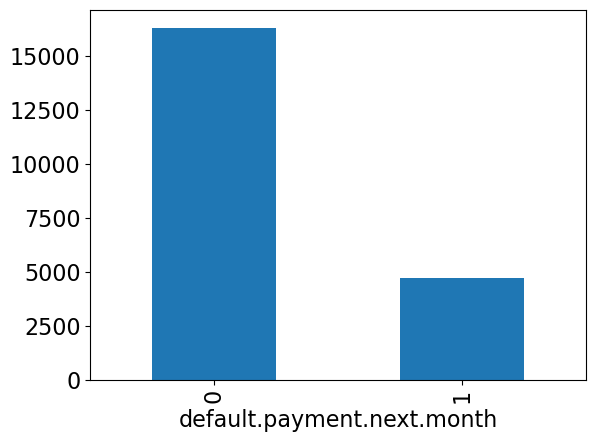

In [10]:
y_train.value_counts().plot(kind = "bar")

There seems to be class imbalance based on the proportions of default.payment.next.month, with 0.777 having no payment next month and 0.223 having payment next month. This means that a dummy classifier that just predicts '0' would have reasonable accuracy.

Metrics

Primary: F1 score, Since “will-default” is our positive class, missing a “will-default” is considered a “false negative”. Since, we want to minimize false negatives we should focus on the recall and F1 metric to see the best performance.

<!-- END QUESTION -->

<br><br>

## 4. Feature engineering

We are averaging all the bill amounts into one feature, as well as the pay amounts into one feature. This is to reduce dimensionality to prevent problems associated with the 'curse of dimensionality'.

In [11]:
credit_df["AVG_BILL_AMT"] = credit_df[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]].mean(axis=1)
credit_df["AVG_PAY_AMT"] = credit_df[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].mean(axis=1)

X = credit_df.drop(columns=['default.payment.next.month', "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"])
y = credit_df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

<!-- END QUESTION -->

<br><br>

## 5. Preprocessing and transformations

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 16396 to 19967
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LIMIT_BAL     21000 non-null  float64
 1   SEX           21000 non-null  int64  
 2   EDUCATION     21000 non-null  int64  
 3   MARRIAGE      21000 non-null  int64  
 4   AGE           21000 non-null  int64  
 5   PAY_0         21000 non-null  int64  
 6   PAY_2         21000 non-null  int64  
 7   PAY_3         21000 non-null  int64  
 8   PAY_4         21000 non-null  int64  
 9   PAY_5         21000 non-null  int64  
 10  PAY_6         21000 non-null  int64  
 11  AVG_BILL_AMT  21000 non-null  float64
 12  AVG_PAY_AMT   21000 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 2.2 MB


In [13]:
numeric_features = ['LIMIT_BAL', 'AGE', 'AVG_BILL_AMT', 'AVG_PAY_AMT']
drop_features = ['SEX'] #unethical?
categorical_features = ['MARRIAGE']
education_features = ['EDUCATION']
ordinal_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

X_train["EDUCATION"] = X_train["EDUCATION"].replace({6: 5, 0: 5})
X_test["EDUCATION"] = X_test["EDUCATION"].replace({6: 5, 0: 5})

In [14]:
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('edu', OrdinalEncoder(categories=[[1, 2, 3, 4, 5]]), education_features),
        ('ord', OrdinalEncoder(categories=[[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]] * len(ordinal_features)), ordinal_features),
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown='ignore'), categorical_features),
        ('drop', "drop", drop_features),
    ]
)

<!-- END QUESTION -->

<br><br>

## 6. Baseline model

In [15]:
## Adapted from CPSC330 Lecture 5
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    kwargs["return_train_score"] = True

    scoring = [
        "f1",
        "recall",
        "accuracy"]
    
    scores = cross_validate(model, X_train, y_train, scoring = scoring, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [16]:
from sklearn.dummy import DummyClassifier

# Baseline model with DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
pipe_dc = make_pipeline(ct, dummy_clf)

results_dict = mean_std_cross_val_scores(
    pipe_dc, X_train, y_train, return_train_score=True
)
pd.DataFrame(results_dict)

/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,0
fit_time,0.044 (+/- 0.016)
score_time,0.022 (+/- 0.003)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_accuracy,0.777 (+/- 0.000)
train_accuracy,0.777 (+/- 0.000)


<!-- END QUESTION -->

<br><br>

## 7. Linear models

In [17]:
results = []

# Perform cross-validation for each value of C
for C in 10.0 ** np.arange(-4, 6, 1):
    lr = LogisticRegression(C=C, max_iter=10000)
    pipe_lr = make_pipeline(ct, lr)
    lr_result = mean_std_cross_val_scores(pipe_lr, X_train, y_train)
    
    # Append C value to the result and convert to DataFrame row
    lr_result["C"] = C
    results.append(lr_result)

# Convert the list of results into a DataFrame
lr_result_df = pd.DataFrame(results)
lr_result_df

/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,C
0,0.056 (+/- 0.018),0.024 (+/- 0.005),0.047 (+/- 0.009),0.047 (+/- 0.003),0.024 (+/- 0.005),0.024 (+/- 0.002),0.780 (+/- 0.001),0.780 (+/- 0.000),0.0001
1,0.057 (+/- 0.005),0.026 (+/- 0.004),0.279 (+/- 0.021),0.279 (+/- 0.009),0.172 (+/- 0.015),0.173 (+/- 0.007),0.801 (+/- 0.004),0.801 (+/- 0.001),0.0010
2,0.087 (+/- 0.017),0.051 (+/- 0.052),0.348 (+/- 0.016),0.350 (+/- 0.008),0.229 (+/- 0.012),0.231 (+/- 0.007),0.809 (+/- 0.003),0.809 (+/- 0.001),0.0100
3,0.120 (+/- 0.013),0.029 (+/- 0.007),0.361 (+/- 0.016),0.361 (+/- 0.008),0.241 (+/- 0.013),0.241 (+/- 0.007),0.810 (+/- 0.003),0.810 (+/- 0.001),0.1000
4,0.090 (+/- 0.017),0.027 (+/- 0.004),0.362 (+/- 0.014),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),1.0000
5,0.087 (+/- 0.016),0.024 (+/- 0.004),0.362 (+/- 0.015),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),10.0000
6,0.092 (+/- 0.013),0.025 (+/- 0.004),0.362 (+/- 0.015),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),100.0000
7,0.087 (+/- 0.021),0.024 (+/- 0.005),0.362 (+/- 0.015),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),1000.0000
8,0.106 (+/- 0.023),0.029 (+/- 0.006),0.362 (+/- 0.014),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),10000.0000
9,0.144 (+/- 0.071),0.035 (+/- 0.006),0.362 (+/- 0.014),0.362 (+/- 0.009),0.241 (+/- 0.013),0.241 (+/- 0.008),0.810 (+/- 0.002),0.810 (+/- 0.001),100000.0000


The linear model slightly improves on the dummy model, with the best train / test accuracy being 0.81. The best hyperparameter value for C seems to be 1.0, since it has the best accuracy combined with a quick fit and score time.

<!-- END QUESTION -->

<br><br>

## 8. Different models

In [18]:
from sklearn.tree import DecisionTreeClassifier

results = []

dt_scores_dict = {
    "max_depth": [1] + list(range(0, 50, 5))[1:] + [None],
}

for max_depth in dt_scores_dict["max_depth"]:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    pipe_dt = make_pipeline(ct, dt)
    dt_result = mean_std_cross_val_scores(pipe_dt, X_train, y_train)
    dt_result["max_depth"] = max_depth
    results.append(dt_result)

dt_result_df = pd.DataFrame(results)
dt_result_df

/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,max_depth
0,0.055 (+/- 0.011),0.028 (+/- 0.005),0.445 (+/- 0.018),0.445 (+/- 0.004),0.326 (+/- 0.015),0.326 (+/- 0.004),0.818 (+/- 0.006),0.818 (+/- 0.001),1.0
1,0.083 (+/- 0.017),0.026 (+/- 0.005),0.468 (+/- 0.013),0.487 (+/- 0.006),0.357 (+/- 0.013),0.371 (+/- 0.007),0.819 (+/- 0.004),0.826 (+/- 0.001),5.0
2,0.114 (+/- 0.023),0.024 (+/- 0.005),0.472 (+/- 0.014),0.579 (+/- 0.014),0.379 (+/- 0.015),0.463 (+/- 0.019),0.811 (+/- 0.007),0.850 (+/- 0.002),10.0
3,0.167 (+/- 0.017),0.032 (+/- 0.004),0.445 (+/- 0.018),0.729 (+/- 0.010),0.381 (+/- 0.023),0.621 (+/- 0.013),0.788 (+/- 0.005),0.897 (+/- 0.003),15.0
4,0.210 (+/- 0.066),0.027 (+/- 0.007),0.420 (+/- 0.012),0.867 (+/- 0.008),0.391 (+/- 0.015),0.790 (+/- 0.016),0.759 (+/- 0.004),0.946 (+/- 0.003),20.0
5,0.181 (+/- 0.021),0.023 (+/- 0.004),0.408 (+/- 0.010),0.951 (+/- 0.007),0.405 (+/- 0.014),0.917 (+/- 0.016),0.738 (+/- 0.004),0.979 (+/- 0.003),25.0
6,0.169 (+/- 0.004),0.018 (+/- 0.002),0.404 (+/- 0.008),0.986 (+/- 0.004),0.413 (+/- 0.011),0.974 (+/- 0.009),0.728 (+/- 0.003),0.994 (+/- 0.002),30.0
7,0.197 (+/- 0.041),0.022 (+/- 0.003),0.404 (+/- 0.010),0.995 (+/- 0.002),0.416 (+/- 0.013),0.990 (+/- 0.005),0.726 (+/- 0.005),0.998 (+/- 0.001),35.0
8,0.182 (+/- 0.017),0.022 (+/- 0.002),0.398 (+/- 0.012),0.997 (+/- 0.001),0.409 (+/- 0.017),0.994 (+/- 0.002),0.724 (+/- 0.004),0.999 (+/- 0.000),40.0
9,0.195 (+/- 0.027),0.022 (+/- 0.004),0.400 (+/- 0.011),0.998 (+/- 0.000),0.412 (+/- 0.014),0.996 (+/- 0.001),0.724 (+/- 0.003),0.999 (+/- 0.000),45.0


The best test_accuracy is at max_depth = 5, with a test_accuracy of 0.819, slightly beating out the linear model. Since the max_depth is not very large, the model is not that complicated, reducing the possibility of overfitting but potentially still underfitting on the complexities of the training data.

In [19]:
results = []

rf_scores_dict = {
    "hps": ["Default"], # for RF, let's just leave the parameters as default␣
}

for hp in rf_scores_dict["hps"]:
    # Create pipeline
    rf = RandomForestClassifier()
    pipe_rf = make_pipeline(ct, rf)
    rf_result = mean_std_cross_val_scores(pipe_rf, X_train, y_train)
    rf_result["hp"] = hp
    results.append(rf_result)

rf_result_df = pd.DataFrame(results)
rf_result_df

/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,hp
0,2.845 (+/- 0.299),0.117 (+/- 0.020),0.470 (+/- 0.010),0.998 (+/- 0.000),0.373 (+/- 0.009),0.997 (+/- 0.000),0.812 (+/- 0.003),0.999 (+/- 0.000),Default


The test_accuracy is better than that of the linear model, but the training accuracy is very close to 1.0 and a lot larger than the test_accuracy, implying that the model is overfitting on the data. Additionally, the fit_time is much larger than the other models used, which means that it could struggle with large datasets.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize results list
results = []

# Define the hyperparameter grid for n_neighbors
knn_scores_dict = {
    "n_neighbors": list(range(1, 21))  # Testing n_neighbors from 1 to 20
}

# Loop over each value of n_neighbors
for n_neighbors in knn_scores_dict["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    pipe_knn = make_pipeline(ct, knn)
    
    # Calculate mean and std cross-validation scores
    knn_result = mean_std_cross_val_scores(pipe_knn, X_train, y_train)
    
    # Add the n_neighbors value to the result and append to results list
    knn_result["n_neighbors"] = n_neighbors
    results.append(knn_result)

# Convert the list of results into a DataFrame
knn_result_df = pd.DataFrame(results)
knn_result_df

/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/xb/qx49vz8d0930c_62scc8m74w0000gn/T/ipykernel_55885/2826699723.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,n_neighbors
0,0.057 (+/- 0.013),0.531 (+/- 0.135),0.402 (+/- 0.005),0.998 (+/- 0.000),0.402 (+/- 0.005),0.997 (+/- 0.001),0.733 (+/- 0.004),0.999 (+/- 0.000),1
1,0.046 (+/- 0.004),0.533 (+/- 0.077),0.323 (+/- 0.011),0.573 (+/- 0.007),0.225 (+/- 0.011),0.401 (+/- 0.007),0.789 (+/- 0.003),0.866 (+/- 0.002),2
2,0.047 (+/- 0.004),0.603 (+/- 0.045),0.434 (+/- 0.012),0.655 (+/- 0.002),0.378 (+/- 0.012),0.568 (+/- 0.003),0.780 (+/- 0.005),0.866 (+/- 0.001),3
3,0.055 (+/- 0.006),0.732 (+/- 0.121),0.382 (+/- 0.013),0.523 (+/- 0.004),0.277 (+/- 0.010),0.381 (+/- 0.003),0.800 (+/- 0.005),0.845 (+/- 0.001),4
4,0.049 (+/- 0.006),0.750 (+/- 0.121),0.446 (+/- 0.018),0.575 (+/- 0.005),0.368 (+/- 0.016),0.473 (+/- 0.003),0.796 (+/- 0.006),0.844 (+/- 0.002),5
5,0.049 (+/- 0.007),0.753 (+/- 0.146),0.400 (+/- 0.019),0.500 (+/- 0.008),0.293 (+/- 0.014),0.368 (+/- 0.008),0.804 (+/- 0.007),0.836 (+/- 0.002),6
6,0.046 (+/- 0.002),0.715 (+/- 0.073),0.451 (+/- 0.013),0.542 (+/- 0.008),0.363 (+/- 0.010),0.436 (+/- 0.009),0.802 (+/- 0.005),0.836 (+/- 0.002),7
7,0.053 (+/- 0.009),0.774 (+/- 0.150),0.425 (+/- 0.015),0.493 (+/- 0.006),0.316 (+/- 0.011),0.365 (+/- 0.007),0.809 (+/- 0.006),0.832 (+/- 0.001),8
8,0.048 (+/- 0.003),0.805 (+/- 0.078),0.459 (+/- 0.012),0.528 (+/- 0.006),0.364 (+/- 0.009),0.419 (+/- 0.007),0.808 (+/- 0.005),0.833 (+/- 0.001),9
9,0.052 (+/- 0.005),0.793 (+/- 0.072),0.430 (+/- 0.018),0.492 (+/- 0.007),0.321 (+/- 0.014),0.368 (+/- 0.007),0.810 (+/- 0.007),0.830 (+/- 0.002),10


The kNN slightly improves on the linear model, with a test_accuracy of 0.813 at around 17 neighbors. With a high number of neighbours, the model's complexity is reduced which could mean that is underfitting on the data.

Out of the four models, the decision tree classifier seems to do better on the data.

<!-- END QUESTION -->

<br><br>

## 9. Feature selection

In [21]:
from sklearn.feature_selection import RFECV

rfe_pipe = make_pipeline(
    ct,
    RFECV(LogisticRegression(max_iter=100), cv=3),
    DecisionTreeClassifier(max_depth = 5)
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       1.556563
score_time     0.011660
test_score     0.818000
train_score    0.818583
dtype: float64

The RFECV does not improve on the decision tree train_score or test_score, but it gets very close. We will abandon this in the next exercises.

<!-- END QUESTION -->

<br><br>

## 10. Hyperparameter optimization

In [22]:
param_grid = {
    "randomforestclassifier__n_estimators": [1, 2, 5, 10, 25, 50, 100, 250],
    "randomforestclassifier__max_depth": [1, 2, 5, 10, 25, 50, 100, 250],
    "randomforestclassifier__max_features": [1, 2, 5, 10, None]
}
pipe_rf = make_pipeline(ct, rf)
random_search = RandomizedSearchCV(pipe_rf, param_distributions=param_grid, scoring="accuracy", n_jobs=-1, 
                                   n_iter=10, cv=5, refit=True, random_state=123)
random_search.fit(X_train, y_train)
results = pd.DataFrame(random_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_features,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.402477,0.017828,0.023479,0.001891,25,5,1,"{'randomforestclassifier__n_estimators': 25, '...",0.800714,0.804762,0.810952,0.796667,0.795714,0.801762,0.005605,7
1,0.191383,0.051881,0.042252,0.016389,10,2,1,"{'randomforestclassifier__n_estimators': 10, '...",0.776905,0.776905,0.776667,0.776667,0.776667,0.776762,0.000117,10
2,1.674718,0.075695,0.090966,0.023596,100,2,5,"{'randomforestclassifier__n_estimators': 100, ...",0.809762,0.808571,0.815952,0.810714,0.805238,0.810048,0.003484,5
3,3.805228,0.101622,0.065885,0.018848,50,None,5,"{'randomforestclassifier__n_estimators': 50, '...",0.814048,0.818810,0.821429,0.827143,0.820714,0.820429,0.004231,1
4,1.711577,0.116587,0.046145,0.019999,10,10,25,"{'randomforestclassifier__n_estimators': 10, '...",0.797381,0.799048,0.802857,0.807381,0.794286,0.800190,0.004536,8
5,7.522622,0.231974,0.064704,0.002217,250,None,2,"{'randomforestclassifier__n_estimators': 250, ...",0.811905,0.814762,0.823810,0.824762,0.816667,0.818381,0.005063,2
6,0.270457,0.017526,0.035981,0.012351,5,1,25,"{'randomforestclassifier__n_estimators': 5, 'r...",0.780238,0.787143,0.796667,0.795714,0.784762,0.788905,0.006356,9
7,3.290257,0.110554,0.063171,0.004084,250,10,1,"{'randomforestclassifier__n_estimators': 250, ...",0.809524,0.814762,0.823810,0.824762,0.816667,0.817905,0.005719,3
8,2.958519,0.127221,0.145497,0.006562,100,1,25,"{'randomforestclassifier__n_estimators': 100, ...",0.803333,0.810000,0.811905,0.819762,0.809762,0.810952,0.005270,4
9,4.819140,0.335846,0.051724,0.003694,50,10,250,"{'randomforestclassifier__n_estimators': 50, '...",0.804524,0.805000,0.808810,0.816429,0.810952,0.809143,0.004358,6


In [23]:
random_search.best_params_

{'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__max_depth': 5}

In [24]:
random_search.best_score_

0.8204285714285714

In [25]:
param_grid = {
    "decisiontreeclassifier__max_depth": [1] + list(range(0, 80, 5))[1:] + [None]
}
pipe_dt = make_pipeline(ct, DecisionTreeClassifier())
random_search_dt = RandomizedSearchCV(pipe_dt, param_distributions=param_grid, scoring="accuracy", n_jobs=-1, 
                                       n_iter=30, cv=5, refit=True, random_state=123)
random_search_dt.fit(X_train, y_train)
results = pd.DataFrame(random_search_dt.cv_results_)
results

/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 17 is smaller than n_iter=30. Running 17 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.061334,0.002628,0.018937,0.000765,1,{'decisiontreeclassifier__max_depth': 1},0.811905,0.814762,0.823810,0.824762,0.816667,0.818381,0.005063,2
1,0.135987,0.014376,0.032385,0.005779,5,{'decisiontreeclassifier__max_depth': 5},0.813333,0.816190,0.820714,0.824048,0.820714,0.819000,0.003778,1
2,0.228561,0.002383,0.020320,0.002083,10,{'decisiontreeclassifier__max_depth': 10},0.801667,0.808333,0.812857,0.814762,0.815476,0.810619,0.005121,3
3,0.234570,0.007770,0.020131,0.002395,15,{'decisiontreeclassifier__max_depth': 15},0.784524,0.793333,0.785952,0.793333,0.783571,0.788143,0.004305,4
4,0.265802,0.011162,0.022026,0.004248,20,{'decisiontreeclassifier__max_depth': 20},0.753810,0.764524,0.757143,0.757857,0.757143,0.758095,0.003509,5
5,0.293840,0.010819,0.021444,0.005938,25,{'decisiontreeclassifier__max_depth': 25},0.736190,0.745000,0.735952,0.734762,0.738333,0.738048,0.003662,6
6,0.307022,0.011599,0.018049,0.002401,30,{'decisiontreeclassifier__max_depth': 30},0.720714,0.732857,0.724048,0.725714,0.729762,0.726619,0.004268,7
7,0.310311,0.013838,0.021241,0.003642,35,{'decisiontreeclassifier__max_depth': 35},0.724048,0.732381,0.721429,0.720238,0.725476,0.724714,0.004258,12
8,0.302484,0.013039,0.024882,0.006189,40,{'decisiontreeclassifier__max_depth': 40},0.724048,0.732381,0.723333,0.720476,0.720476,0.724143,0.004369,14
9,0.349201,0.056035,0.022961,0.003790,45,{'decisiontreeclassifier__max_depth': 45},0.721429,0.733810,0.725714,0.723571,0.727619,0.726429,0.004232,8


In [26]:
random_search_dt.best_params_

{'decisiontreeclassifier__max_depth': 5}

In [27]:
random_search_dt.best_score_

0.8190000000000002

<!-- END QUESTION -->

<br><br>

## 11. Interpretation and feature importances

In [28]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(max_depth=5, random_state=123))
pipe_dt.fit(X_train, y_train_num)

feature_names=ct.get_feature_names_out()

data = {
    "Importance": pipe_dt.named_steps["decisiontreeclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
ord__PAY_0,0.666847
ord__PAY_2,0.140973
num__AVG_PAY_AMT,0.058068
ord__PAY_4,0.039978
num__AVG_BILL_AMT,0.023924
ord__PAY_6,0.023093
num__AGE,0.015182
num__LIMIT_BAL,0.012183
ord__PAY_3,0.010719
ord__PAY_5,0.005704


The most important feature is PAY_0, which is the repayment status in September, which is the most recent status. This makes sense as it is most indicative of a client's current financial record, especially because PAY_2 is the next most important feature, which was the repayment status in August, the second most recent.

<!-- END QUESTION -->

<br><br>

## 12. Results on the test set

In [29]:
dt = RandomForestClassifier(n_estimators=50, max_features=None, max_depth=5, random_state=123)
pipe_dt = make_pipeline(ct, dt)
pipe_dt.fit(X_train, y_train)

y_train_pred = pipe_dt.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=["non-default", "default"]))

              precision    recall  f1-score   support

 non-default       0.84      0.96      0.90     16312
     default       0.71      0.38      0.49      4688

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.69     21000
weighted avg       0.81      0.83      0.81     21000



In [30]:
y_test_pred = pipe_dt.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=["non-default", "default"]))

              precision    recall  f1-score   support

 non-default       0.85      0.95      0.89      7052
     default       0.66      0.37      0.48      1948

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



The test scores are very similar to the validation scores which implies that the model is not overfitting on the training data. We can trust that our results have minimal optimization bias due to how close the training and test scores are. The very small difference in the scores could be due to random chance.

<!-- END QUESTION -->

<br><br>

## 13. Summary of results

In this investigation, we developed a model that uses a person's pertinent credit history and other demographic data to forecast whether or not they would miss their next credit card payment. We started by doing some preliminary data analysis and data wrangling. Once the pertinent data has been understood, we develop many models and run cross-validation on them to see how well they will work with our test data. On average, linear models performed worse than our tree-based models; the random forest classifier in particular was immediately considered for additional testing. We decided to use that model.

| Model            | Best Hyperparameters                                                | Best CV Score |
|------------------|-----------------------------------------------------------------|---------------|
| Random Forest    | `n_estimators=50`, `max_features=None`, `max_depth=5`      | 0.826         |
| Decision Tree    | `max_depth=5`   | 0.819         |
| Logistic Regression              | `C=1`                             | 0.810         |
| kNN Classification              | `n_neighbours=17`                             | 0.813         |


| Model            | Best Hyperparameters                                                | Best CV Score | Test Score | Precision | Recall | F1 Score
|------------------|-----------------------------------------------------------------|---------------|---------------|---------------|---------------|---------------|
| Random Forest    | `n_estimators=50`, `max_features=None`, `max_depth=5`    | 0.83         | 0.82 |  0.66   |   0.37  |    0.48


The best performing model was of type RandomForestClassifier with the above hyperparameters, which had a test score of 0.82 while the cross validation score was very similar, implying that the model did not overfit. We could have tried other models such as Linear SVM. An idea we did not try but could improve the performance is to optimize the recall. This would minimize the amount of false negatives which is preferable to increase the amount of defaulting clients detected. This could be done by lowering the decision threshold with predict_proba.

<br><br>

## 14. Takeaways

It was difficult keeping track of all the steps in a cohesive format. The most important step is making sure we didn't violate the Golden Rule by not letting the test data interfere with the training, particularly in preprocessing and transformation steps. The biggest takeaway is that each model performs differently for different types of data, and making sure we have the right model increases the trustworthiness of our model.

## 15. Acknowledgements

We would like to express our sincere gratitude to the instructors and teaching assistants of CPSC 330: Applied Machine Learning at the University of British Columbia. Their guidance, support, and insightful lectures provided us with a strong foundation in machine learning concepts and practical skills. This analysis was adapted from a open-ended homework assignment.

Special thanks for designing thought-provoking assignments like this one, which challenged us to apply our knowledge to real-world problems and enhance our critical thinking. The feedback and resources provided throughout the course were invaluable in deepening our understanding of the subject.

This project would not have been possible without their dedication to fostering a collaborative and enriching learning environment. Thank you for inspiring us to explore the fascinating field of machine learning!